In [1]:
!pip install stable_baselines3
!pip install gym[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ale_py-0.7.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached mujoco-py-1.50.1.68.tar.gz (120 kB)
  Using cached lz4-4.0.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build box2d-py mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-l6q9knke/mujoco-py_52d12486abd946cfb8796fb4626801e5/setup.py'"'"'; __file__='"'"'/tmp/pip-install-l6q9knke/mujoco-py_

In [2]:
import numpy as np

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from IPython.utils import tempdir
import gym, torch, numpy as np, torch.nn as nn
from gym import spaces

class SimulateSawEnv(gym.Env):
  

    def __init__(self, render_mode=None, dt = .05):
        
        self.mu_a = 0.5 # amonton's law
        self.mu_c = 0.5 # coulomb's law
        self.num_steps = 0
        # length of the saw
        self.L = 0.8
        # state vector
        self.state = [self.L/10, 0, 0, 0] # d, theta, dd, dtheta
        # mass of the saw-drone system
        self.m = 0.5
        # moment of inertia with centered inertia = 0.05
        self.I = 0.05 + self.m*(self.state[0]-self.L/2)**2
        # Do we want cvxopt?
        self.en_cvx = False
        # Do we want constains?
        self.en_constrain = True
        # simulation time
        self.time_out = 20
        # number of motors
        self.n = 4
        # position of the thrusters from the left side of the drone
        self.p = np.array([[self.L/8, 0], [3*self.L/8, 0], [5*self.L/8, 0], [7*self.L/8, 0]]).T
        # position of the contact point on the drone
        self.p_c = np.array([self.state[0], 0])
        # tilting angles of the propellers
        self.alpha = np.array([-30, 30, -30, 30])*np.pi/180.0
        # gravity acceleration
        self.g = 9.8
        # time step
        self.dt = dt#0.005
        # max force of a propeller
        self.fM = 20.0
        # minimum force of a propeller
        self.fm = 0

        # A-matrix of the quadrotor
        # force part remains unchanged, good thing everything is local now
        self.Af = np.zeros([2, self.n]);
        # torque should change based on d
        self.Atau = np.zeros([1, self.n]);
        self.R = np.zeros([2, 2*self.n]);
        for i in range(self.n):
            self.R[:, 2*i:2*i+2] = [[np.cos(self.alpha[i]), -np.sin(self.alpha[i])],
                            [np.sin(self.alpha[i]), np.cos(self.alpha[i])]]
            self.Af[:,i] = self.R[:, 2*i:2*i+2].dot(np.array([0, 1]))
            self.Atau[:,i] = np.cross(self.p[:,i]-self.p_c, self.R[:, 2*i:2*i+2].dot(np.array([0, 1])))

        self.A = np.concatenate([self.Af, self.Atau], axis=0)

        self.action_space = spaces.Box(np.array([-1, -1]), np.array([1, 1]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(np.array([0, -np.pi/2,-5,-5]), np.array([self.L, np.pi/2,5,5]), shape=(4,), dtype=np.float32)
        

        #Temporary goal state
        self.goal_d = self.L*.9

        
    def _get_obs(self):
        return np.array(self.state, dtype=np.float32)
    
    def _get_info(self):
        return {}#self.state[0] - self.goal_d#{"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}
    
    def reset(self, seed=None, options=None):
        #self.close()
        # We need the following line to seed self.np_random
        #super().reset()#seed=seed)
        self.state = [self.L/10, 0, 0, 0] # d, theta, dd, dtheta
        self.I = 0.05 + self.m*(self.state[0]-self.L/2)**2
        self.num_steps = 0
        self.p_c = np.array([self.state[0], 0])
        # tilting angles of the propellers
        self.alpha = np.array([-30, 30, -30, 30])*np.pi/180.0

        self.fM = 20.0
        # minimum force of a propeller
        self.fm = 0
        
        self.Af = np.zeros([2, self.n]);
        # torque should change based on d
        self.Atau = np.zeros([1, self.n]);
        self.R = np.zeros([2, 2*self.n]);
        for i in range(self.n):
            self.R[:, 2*i:2*i+2] = [[np.cos(self.alpha[i]), -np.sin(self.alpha[i])],
                            [np.sin(self.alpha[i]), np.cos(self.alpha[i])]]
            self.Af[:,i] = self.R[:, 2*i:2*i+2].dot(np.array([0, 1]))
            self.Atau[:,i] = np.cross(self.p[:,i]-self.p_c, self.R[:, 2*i:2*i+2].dot(np.array([0, 1])))

        self.A = np.concatenate([self.Af, self.Atau], axis=0)

        observation = self._get_obs()
        info = self._get_info()


        return observation
    
    def step(self, action):
        # finds the forces of the motors based on the action accelerations
        f = self.ideal_controller(action[0]*20, action[1]*5)
        # calcuates new state from the motor forces
        next_state = self.part_step(f)
        # finds if state is terminal, and its reward
        reward, terminated = self.evaluate(next_state)
        self.state = next_state
        self.num_steps += 1
        return self._get_obs(), reward, terminated, {"f":f}

    # Evaluates the state for its rewards and terminality
    def evaluate(self, next_state):
        
        terminated = False
        reward = 0
        # all fail conditions
        if self.num_steps > 350 or \
                next_state[2] > 4 or next_state[2] < -4 or \
                next_state[3] > 4 or next_state[3] < -4 or \
                next_state[0] < 0 or next_state[0] > self.L or abs(next_state[1]) >= np.pi/2:
            reward = -300 
            terminated = True
        # goal condition
        elif next_state[0] >= self.goal_d and \
                abs(next_state[2]) < .05:
            reward = 6000 - self.num_steps * 10 - (10*abs(next_state[2]))**2 - 10*abs(next_state[3])
            terminated = True
            if reward < 1000:
                reward = 1000
        else:
        # step rewards to encorage moving torwards goal
            reward = -5*(abs(next_state[0] - self.goal_d))**.5
            
        return reward, terminated


    def ideal_controller(self, ddd, ddtheta):
        f = np.linalg.pinv(self.A).dot(np.array([-ddd*self.m, 0, ddtheta*self.I]))
        if self.en_constrain: 
            return self.clamp(f, self.fm, self.fM)
        else:
            return f
        return f
    
    # step function for the motion of the saw-drone
    def part_step(self, u):
        
        d, theta, dd, dtheta = self.state

        # change the torque part of the A matrix based on d
        self.p_c = np.array([d, 0])
        for i in range(self.n):
            self.A[2,i] = np.cross(self.p[:,i] - self.p_c, self.R[:, 2*i:2*i+2].dot(np.array([0, 1])))

        # calculate the wrench generated by the drone
        w = self.A.dot(u)
        # print(w)

        # obatin the wrench applied by the object on the drone
        contact_wrench = self.sawee_wrench(self.state, w)

        # print(state)
        # print(contact_wrench)
        # print()

        # since gravity apllies on the CoM, there could be a force arm
        tau_g = -(self.L/2-d)*self.m*self.g*np.cos(theta)
        # gravity wrench projected in the drone's local frame
        gravity_wrench = np.array([-self.m*self.g*np.sin(theta), -self.m*self.g*np.cos(theta), tau_g])
        # and the total wrench received by the drone
        fx, fy, tau = w + contact_wrench + gravity_wrench
        # print(fy)
        # assert np.allclose(fy, 0) # just some check

        self.I = 0.05 + self.m*(d-self.L/2)**2
        
        # locally, x is in the oppposite direction of d
        # - the more the drone moves toward positive x, the smaller d is
        dstate = np.array([dd, dtheta, -fx/self.m, tau/self.I])
        new_state = self.state + dstate*self.dt
        # make sure the range of theta is in (-pi, pi]
        if new_state[1] <= -np.pi:
            new_state[1] += 2*np.pi
        elif new_state[1] > np.pi:
            new_state[1] -= 2*np.pi
        return new_state
    
    def clamp(self, vec, minimum, maximum):
        for i in range(len(vec)):
            if vec[i] < minimum:
                vec[i] = minimum
            elif vec[i] > maximum:
                vec[i] = maximum
        return vec

    def sawee_wrench(self, state, drone_wrench):
        d, theta, dd, dtheta = state

        # we want to achieve balance in the normal direction of the robot
        local_force_y = drone_wrench[1]
        gravity_local_y = -self.m*self.g*np.cos(theta)
        contact_normal_force = - local_force_y - gravity_local_y # "up" direction, 
                                                                # may be negative haha
        contact_tangent_force = self.mu_a*contact_normal_force*self.mu_c*dd # friction has to 
                                                                # fight against 
                                                                # the intention to
                                                                # move in x direction
                                                                # nevertheless, which 
                                                                # is moving in d
                                                                # direction, yep

        return np.array([contact_tangent_force, max(contact_normal_force, 0), 0])

# Learning Step

In [3]:
env = SimulateSawEnv()

#establishes the model using DDPG with a multi layer perceptron policy/critic
model = DDPG("MlpPolicy",  env, verbose=1,learning_starts=200)

#learns over a limited number of timesteps
print("starting learning process")
model.learn(total_timesteps=100000, log_interval=10)
model.save("ddpg_saw")



/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
starting learning process
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.9     |
|    ep_rew_mean     | -355     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 1624     |
|    time_elapsed    | 0        |
|    total_timesteps | 169      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.2     |
|    ep_rew_mean     | -339     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 196      |
|    time_elapsed    | 1        |
|    total_timesteps | 243      |
| train/             |          |
|    actor_loss      | 25.5     |
|    critic_loss     | 4.89e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 52       |
---------------------------------
-----------------------------

In [4]:
# this block can be used if extra training is needed on the model 
#model = DDPG.load("ddpg_saw", env=env)
#model.learn(total_timesteps=100000, log_interval=10)
#model.save("ddpg_saw")

# Simulation with trained policy

In [46]:
import pickle
# can choose a smaller dt for extra datapoints, however there is no garuntee 
#       that the policy was trained enough to account for the higher precision
env = SimulateSawEnv(dt = .01)
model = DDPG.load("ddpg_saw")
state_array = [ ]
f_array = [ ]
obs = env.reset()
#prints an example model from start to finish
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, f = env.step(action)
    print(obs, dones)
    state_array.append(obs)
    f_array.append(f["f"])
    if dones:
        break


/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


[ 0.08        0.          0.05419836 -0.01827177] False
[ 0.08054198 -0.00018272  0.10188629 -0.05452655] False
[ 0.08156085 -0.00072798  0.1449464  -0.10307088] False
[ 0.08301031 -0.00175869  0.19227928 -0.13983251] False
[ 0.0849331  -0.00315702  0.24819213 -0.15421951] False
[ 0.08741502 -0.00469921  0.3078195  -0.15920074] False
[ 0.09049322 -0.00629122  0.36927095 -0.15922177] False
[ 0.09418593 -0.00788344  0.431701   -0.15617305] False
[ 0.09850294 -0.00944517  0.49111116 -0.1571733 ] False
[ 0.10341405 -0.0110169   0.5481016  -0.16037245] False
[ 0.10889506 -0.01262063  0.60378605 -0.1780835 ] False
[ 0.11493292 -0.01440146  0.65694714 -0.2082316 ] False
[ 0.1215024  -0.01648378  0.7094925  -0.23926282] False
[ 0.12859732 -0.01887641  0.76104856 -0.27185258] False
[ 0.1362078  -0.02159493  0.8091275  -0.31093633] False
[ 0.14429909 -0.02470429  0.8556782  -0.35229918] False
[ 0.15285587 -0.02822728  0.9014231  -0.39434287] False
[ 0.16187009 -0.03217071  0.9455888  -0.43841004

In [47]:

filename = "state_array"
fileObject = open(filename, 'wb')
pickle.dump(np.array(state_array), fileObject)
fileObject.close()

filename = "f_array"
fileObject = open(filename, 'wb')
pickle.dump(np.array(f_array), fileObject)
fileObject.close()

# Data inspection

In [48]:
import pickle
file_state = open('state_array', 'rb')
data_state = pickle.load(file_state)

file_f = open('f_array', 'rb')
data_f = pickle.load(file_f)
print(len(data_state), len(data_f))

152 152


In [49]:
import numpy as np
data = np.array(data_state)
f_log = np.array(data_f)

# process the state log so that they look more like a normal multi-rotor state
# let's say the contact point has a height of h
h = 0.5
L = 0.8
width = 0.1
n = 4
dt = 0.01

def states_conversion(dthetastate):
    # we should be able to make this function applicable to the entire state log
    # but let's not worry about that for now
    d, theta, dd, dtheta = dthetastate
    x = (L/2 - d)*np.cos(theta)
    y = (L/2 - d)*np.sin(theta) + h
    dx = -dd*np.cos(theta) - (L/2 - d)*np.sin(theta)
    dy = -dd*np.sin(theta) + (L/2 - d)*np.cos(theta)
    return np.array([x, y, theta, dx, dy, dtheta])

xythetastate = []
for i in range(data.shape[0]):
    xythetastate.append(states_conversion(data[i, :]))

state_log = np.array(xythetastate)

# smoothify the input force?
kernel_size = 8
kernel = np.ones(kernel_size) / kernel_size
f_convolved_8 = np.copy(f_log)
for i in range(n):
    f_convolved_8[:, i] = np.convolve(f_log[:, i], kernel, mode='same')

[[<matplotlib.lines.Line2D at 0x7f6b783af850>],

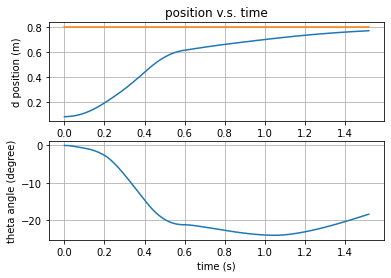

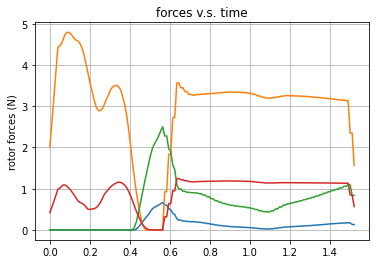

In [52]:
import matplotlib.pyplot as plt

time_out = dt*state_log.shape[0]

cut = 168
fig1 = plt.figure()
ax11 = fig1.add_subplot(211)
ax11.grid()
ax11.set_ylabel('d position (m)')
ax11.set_title('position v.s. time')
x_position, = ax11.plot(np.linspace(0, time_out, state_log.shape[0])[:cut], data[:cut, 0])
desx_position, = ax11.plot([0.0, time_out],[L, L])


ax13 = fig1.add_subplot(212)
ax13.grid()
ax13.set_ylabel('theta angle (degree)')
ax13.set_xlabel('time (s)')
theta_angle, = ax13.plot(np.linspace(0, time_out, state_log.shape[0])[:cut], data[:cut, 1]*180.0/np.pi)

fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.grid()
ax2.set_ylabel('rotor forces (N)')
ax2.set_title('forces v.s. time')
[ax2.plot(np.linspace(0, time_out, state_log.shape[0])[:cut], f_convolved_8[:cut, i]) for i in range(n)]


In [53]:
!pip install JSAnimation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


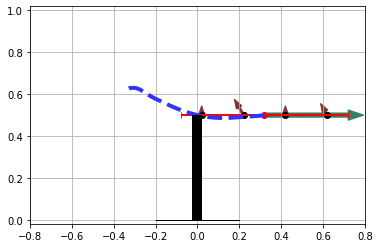

In [54]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

fig, ax = plt.subplots()
plt.axis('equal')
sampling = int(1)

dt = 0.05
n = 4
# position of the thrusters from the CoM of the drone
p = np.array([[-3*L/8, 0], [-L/8, 0], [L/8, 0], [3*L/8, 0]]).T

# tilting angles of the propellers
alpha = np.array([-30, 30, -30, 30])*np.pi/180.0

# orientation of the rotors
R = np.zeros([2, 2*n]);
for i in range(n):
    R[:, 2*i:2*i+2] = [[np.cos(alpha[i]), -np.sin(alpha[i])],
                       [np.sin(alpha[i]), np.cos(alpha[i])]]

def animate(t):
    ax.clear()
    plt.xlim([-0.8, 0.8])
    plt.ylim([-0.2, 1.2])
    ax.grid()

    # current position and orientation
    ax.plot(state_log[sampling*t, 0], state_log[sampling*t, 1], 'ro')  # Center of mass
    ax.arrow(state_log[sampling*t, 0], state_log[sampling*t, 1], L/2*np.cos(state_log[sampling*t,2]), 
             L/2*np.sin(state_log[sampling*t,2]), width=0.02, color=[0.2,0.5,0.4], head_width = 0.05)
    # actuators
    # homogeneous vectors and rotations
    pos_p = np.zeros([2, n])
    rot_p = np.zeros([2, n])

    # drone frame left and right ends
    pos_e = np.zeros([2, 2])

    # homogenenous transformation for the current state
    T = np.eye(3)
    T[0:2, 0:2] = np.array([[np.cos(state_log[sampling*t, 2]), -np.sin(state_log[sampling*t, 2])],
                            [np.sin(state_log[sampling*t, 2]), np.cos(state_log[sampling*t, 2])]])
    T[0:2, 2] = state_log[sampling*t, 0:2]
    for i in range(n):
        pos_p[:, i] = T.dot(np.array([p[0, i], p[1, i], 1]))[0:2]
        rot_p[:, i] = T[0:2, 0:2].dot(R[:, 2*i:2*i+2].dot(0.03*np.sqrt(f_convolved_8[sampling*t, i])*np.array([0, 1])))
    
    # drone frame
    pos_e[:, 0] = T.dot(np.array([-L/2, 0, 1]))[0:2]
    pos_e[:, 1] = T.dot(np.array([L/2, 0, 1]))[0:2]

    ax.plot(pos_p[0, :], pos_p[1, :], 'k-o')
    ax.plot([pos_e[0,-1], pos_e[0,0]], [pos_e[1, -1], pos_e[1, 0]], 'r-|', linewidth=2, solid_capstyle="butt")
    
    for i in range(n):
        ax.arrow(pos_p[0, i], pos_p[1, i], rot_p[0, i], rot_p[1, i], width=0.01, color=[0.5,0.2,0.2])
    # Path
    plt.plot(state_log[:, 0], state_log[:, 1], '--', color=[0.2, 0.2, 1.0], linewidth=4)

    # object that is being sawed
    ax.plot([0.0, 0.0], [0.0, h], color=[0.0, 0.0, 0.0], linewidth=10, solid_capstyle="butt")
    ax.plot([-0.2, 0.2], [0.0, 0.0], color=[0.0, 0.0, 0.0], linewidth=1)


time = int(len(state_log)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=dt*1000*sampling)

# HTML(anim.to_jshtml())
anim.save("video.mp4")